<a href="https://colab.research.google.com/github/Mihail-Chr/projects/blob/main/NLP/NLP_toz_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install catboost
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import numba as nb
from numba import njit, prange,jit
import cupy as cp
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Инициализация устройств
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Конфигурация
MAX_LEN = 128
BATCH_SIZE = 32

Используемое устройство: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Загрузка данных

def load_data(path):
    return pd.read_csv(path)

print("Загрузка данных...")
df = load_data('/content/drive/MyDrive/data/toxic_comments.csv')

# Явное приведение к строке

def convert_to_string(obj):

    return str(obj).encode('utf-8').decode('utf-8')

#df['text'] = convert_to_string(df['text'])

Загрузка данных...


In [ ]:
# Предобработка текста

def preprocess_text_gpu(texts):
    processed = []
    for i in prange(len(texts)):
        text = str(texts[i]).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        processed.append(text)
    return processed

print("Предобработка текста...")
df['text_clean'] = preprocess_text_gpu(df['text'].values)
y = df['toxic'].values

Предобработка текста...


In [ ]:
df.head()

,Unnamed: 0,text,toxic,text_clean
0,0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...
1,1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,\nmore\ni cant make any real suggestions on im...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [ ]:
# 1. TF-IDF Токенизация
print("TF-IDF токенизация...")
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1, 5),stop_words= 'english')
X_tfidf = tfidf.fit_transform(df['text_clean'])


TF-IDF токенизация...


<159292x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3357178 stored elements in Compressed Sparse Row format>

In [ ]:
X_tfidf[0]

NameError: name 'X_tfidf' is not defined

In [ ]:
# 2. Word2Vec Токенизация

def tokenize_texts(texts):
    tokens = []
    for i in prange(len(texts)):
        tokens.append(simple_preprocess(str(texts[i]), deacc=True))
    return tokens

print("Word2Vec токенизация...")
sentences = tokenize_texts(df['text_clean'].values)

print("Обучение Word2Vec модели...")
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


def text_to_vector_gpu(texts, model):
    vectors = np.empty((len(texts), model.vector_size), dtype=np.float32)
    for i in prange(len(texts)):
        words = simple_preprocess(str(texts[i]), deacc=True)
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        vectors[i] = np.mean(word_vecs, axis=0) if len(word_vecs) > 0 else np.zeros(model.vector_size)
    return vectors

print("Создание Word2Vec векторов...")
X_w2v = text_to_vector_gpu(df['text_clean'].values, w2v_model)

Word2Vec токенизация...
Обучение Word2Vec модели...
Создание Word2Vec векторов...


In [ ]:
# 3. BERT Токенизация и получение эмбеддингов
print("Инициализация BERT...")
bert_tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert') #('bert-base-uncased')
bert_model = BertModel.from_pretrained(('unitary/toxic-bert')).to(device)


def bert_tokenize(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

print("BERT токенизация...")
input_ids, attention_masks = bert_tokenize(df['text_clean'].tolist())


def get_bert_embeddings(input_ids, attention_masks):
    bert_model.eval()
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), BATCH_SIZE)):
            batch_ids = input_ids[i:i+BATCH_SIZE].to(device)
            batch_masks = attention_masks[i:i+BATCH_SIZE].to(device)

            outputs = bert_model(batch_ids, attention_mask=batch_masks)
            embeddings.append(outputs.last_hidden_state[:,0,:].cpu().numpy())

    return np.concatenate(embeddings, axis=0)

print("Получение BERT эмбеддингов...")
X_bert = get_bert_embeddings(input_ids, attention_masks)

Инициализация BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BERT токенизация...
Получение BERT эмбеддингов...


100%|██████████| 4978/4978 [16:07<00:00,  5.15it/s]


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Модели с GPU поддержкой
models = {
    'CatBoost': CatBoostClassifier(task_type='GPU', iterations=500, verbose=0),
    'XGBoost': XGBClassifier(tree_method='gpu_hist', gpu_id=0),
    'LightGBM': LGBMClassifier(device='gpu')
}

# Кросс-валидация
def evaluate_model(X, y, model, n_splits=3):
    scores = []
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    fold_size = X.shape[0] // n_splits

    for i in range(n_splits):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])

        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        scores.append(f1_score(y[test_idx], y_pred))

    return np.mean(scores), np.std(scores)



Оценка моделей:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:14] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [

[LightGBM] [Info] Number of positive: 10712, number of negative: 95483
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 478778
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 4395
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100871 -> initscore=-2.187584
[LightGBM] [Info] Start training from score -2.187584


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10876, number of negative: 95319
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 484263
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 4395
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102415 -> initscore=-2.170671
[LightGBM] [Info] Start training from score -2.170671


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10784, number of negative: 95411
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 480173
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 4395
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101549 -> initscore=-2.180130
[LightGBM] [Info] Start training from score -2.180130


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10685, number of negative: 95510
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (10.13 MB) transferred to GPU in 0.013167 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100617 -> initscore=-2.190390
[LightGBM] [Info] Start training from score -2.190390


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10838, number of negative: 95357
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (10.13 MB) transferred to GPU in 0.012193 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102058 -> initscore=-2.174569
[LightGBM] [Info] Start training from score -2.174569


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10849, number of negative: 95346
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (10.13 MB) transferred to GPU in 0.011544 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102161 -> initscore=-2.173439
[LightGBM] [Info] Start training from score -2.173439


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10850, number of negative: 95345
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 768
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (77.78 MB) transferred to GPU in 0.146449 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102171 -> initscore=-2.173337
[LightGBM] [Info] Start training from score -2.173337


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10770, number of negative: 95425
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 768
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (77.78 MB) transferred to GPU in 0.154261 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101417 -> initscore=-2.181576
[LightGBM] [Info] Start training from score -2.181576


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10752, number of negative: 95443
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 106195, number of used features: 768
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (77.78 MB) transferred to GPU in 0.153481 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101248 -> initscore=-2.183437
[LightGBM] [Info] Start training from score -2.183437


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Результаты кросс-валидации:
     Модель Токенизация        F1       Std
0  CatBoost      TF-IDF  0.688348  0.004464
1  CatBoost    Word2Vec  0.665625  0.005543
2  CatBoost        BERT  0.912706  0.001167
3   XGBoost      TF-IDF  0.235549  0.014696
4   XGBoost    Word2Vec  0.673331  0.003744
5   XGBoost        BERT  0.909223  0.002964
6  LightGBM      TF-IDF  0.723722  0.003493
7  LightGBM    Word2Vec  0.658999  0.007405
8  LightGBM        BERT  0.910939  0.001690

Анализ текста с CatBoost...


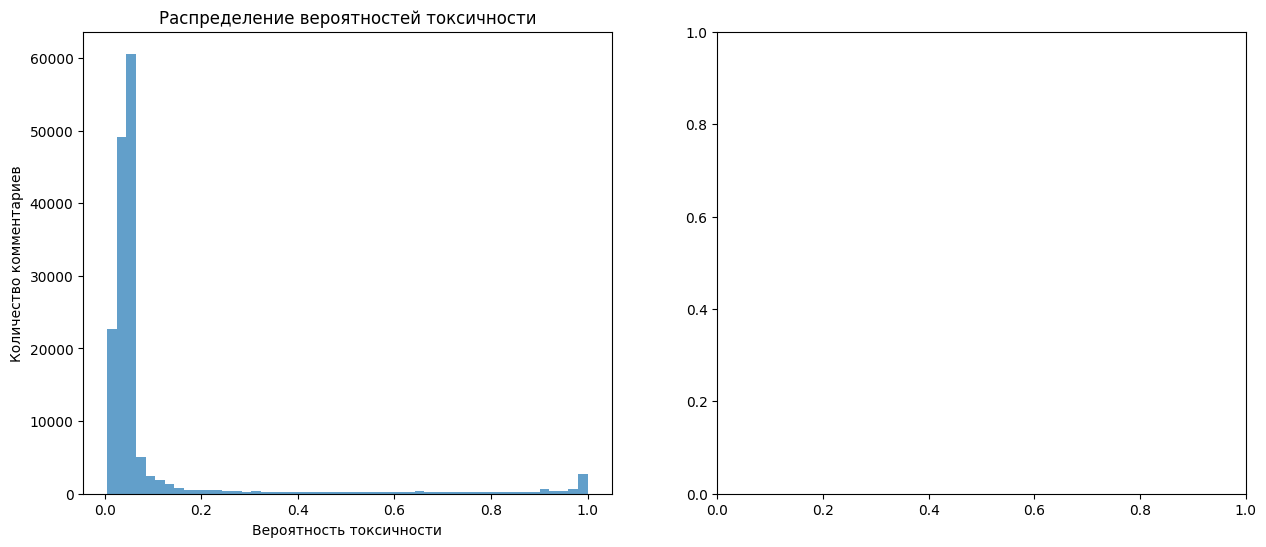

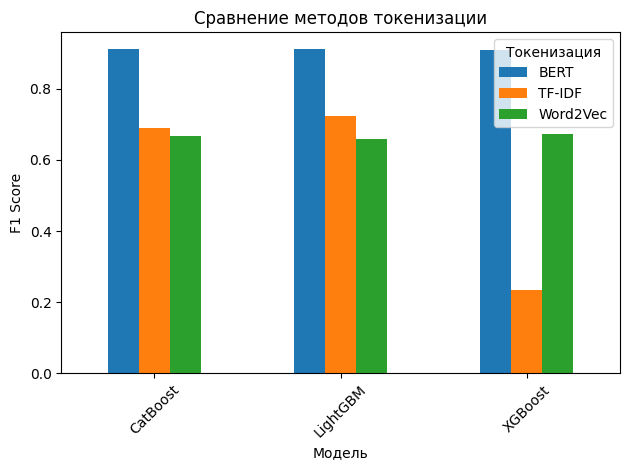

In [ ]:

# Оценка всех комбинаций
results = []

print("\nОценка моделей:")
for name, model in models.items():
    # TF-IDF
    mean_f1, std_f1 = evaluate_model(X_tfidf, y, model)
    results.append({'Модель': name, 'Токенизация': 'TF-IDF', 'F1': mean_f1, 'Std': std_f1})

    # Word2Vec
    mean_f1, std_f1 = evaluate_model(X_w2v, y, model)
    results.append({'Модель': name, 'Токенизация': 'Word2Vec', 'F1': mean_f1, 'Std': std_f1})

    # BERT
    mean_f1, std_f1 = evaluate_model(X_bert, y, model)
    results.append({'Модель': name, 'Токенизация': 'BERT', 'F1': mean_f1, 'Std': std_f1})

# Результаты
results_df = pd.DataFrame(results)
print("\nРезультаты кросс-валидации:")
print(results_df)



plt.figure(figsize=(15, 6))
results_df.groupby(['Модель', 'Токенизация'])['F1'].mean().unstack().plot(kind='bar')
plt.title('Сравнение методов токенизации')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
#

 Анализ с CatBoost
# Функция для анализа текста с CatBoost

def analyze_text_with_catboost(texts, vectorizer, model):
    X = vectorizer.transform(texts)
    results = np.empty(len(texts), dtype=np.float32)
    for i in prange(len(texts)):
        results[i] = model.predict_proba(X[i])[0][1]
    return results

print("\nАнализ текста с CatBoost...")
best_model = CatBoostClassifier(task_type='GPU', iterations=500, verbose=0)
best_model.fit(X_tfidf, y)
text_analysis = analyze_text_with_catboost(df['text_clean'].values, tfidf, best_model)

# Визуализация
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(text_analysis, bins=50, alpha=0.7)
plt.title('Распределение вероятностей токсичности')
plt.xlabel('Вероятность токсичности')
plt.ylabel('Количество комментариев')

In [ ]:
# CNN модель
def build_cnn_model(vocab_size=5000, max_len=100):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Кросс-валидация
def evaluate_models(X, y, vectorizers, models):
    results = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for vec_name, vec in vectorizers.items():
        for model_name, model in models.items():
            pipeline = Pipeline([('vectorizer', vec), ('model', model)])
            scores = cross_val_score(pipeline, X, y, cv=skf, scoring='f1', n_jobs=-1)
            results.append({
                'vectorizer': vec_name,
                'model': model_name,
                'f1_mean': np.mean(scores),
                'f1_std': np.std(scores)
            })

    return pd.DataFrame(results)

In [ ]:
# Оценка для каждого типа токенизации
results_simple = evaluate_models(X['text_simple'], y, vectorizers, models)
results_lemmatized = evaluate_models(X['text_lemmatized'], y, vectorizers, models)
results_pos = evaluate_models(X['text_pos'], y, vectorizers, models)

# Объединение результатов
results_all = pd.concat([
    results_simple.assign(tokenization='simple'),
    results_lemmatized.assign(tokenization='lemmatized'),
    results_pos.assign(tokenization='pos_tags')
])

# CNN оценка
def evaluate_cnn(X_texts, y, tokenization_type):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_texts)
    X_seq = tokenizer.texts_to_sequences(X_texts)
    X_pad = pad_sequences(X_seq, maxlen=100)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, test_idx in skf.split(X_pad, y):
        model = build_cnn_model()
        model.fit(X_pad[train_idx], y[train_idx], epochs=3, batch_size=64, verbose=0)
        y_pred = (model.predict(X_pad[test_idx]) > 0.5).astype(int)
        f1_scores.append(f1_score(y[test_idx], y_pred))

    return {
        'vectorizer': 'embedding',
        'model': 'CNN',
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'tokenization': tokenization_type
    }

# Добавляем CNN результаты
cnn_results = [
    evaluate_cnn(X['text_simple'], y, 'simple'),
    evaluate_cnn(X['text_lemmatized'], y, 'lemmatized'),
    evaluate_cnn(X['text_pos'], y, 'pos_tags')
]

results_all = pd.concat([results_all, pd.DataFrame(cnn_results)])

NameError: name 'X' is not defined

In [ ]:
# Анализ результатов
print("Лучшие комбинации по типу токенизации:")
print(results_all.groupby('tokenization').apply(lambda x: x.nlargest(3, 'f1_mean')))

print("\nЛучшие комбинации по модели:")
print(results_all.groupby('model').apply(lambda x: x.nlargest(3, 'f1_mean')))

print("\nЛучшие комбинации по векторйзеру:")
print(results_all.groupby('vectorizer').apply(lambda x: x.nlargest(3, 'f1_mean')))

# Визуализация
plt.figure(figsize=(15, 8))
for token_type in results_all['tokenization'].unique():
    subset = results_all[results_all['tokenization'] == token_type]
    plt.errorbar(subset['model'], subset['f1_mean'], yerr=subset['f1_std'],
                fmt='o', label=token_type, capsize=5)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('Сравнение моделей по типам токенизации')
plt.legend()
plt.tight_layout()
plt.show()